# Model Predictive Control: Aircraft Model

RMM, 13 Feb 2021

This example replicates the [MPT3 regulation problem example](https://www.mpt3.org/UI/RegulationProblem).

In [1]:
import control as ct
import numpy as np
import control.optimal as obc
import matplotlib.pyplot as plt

In [2]:
# model of an aircraft discretized with 0.2s sampling time
# Source: https://www.mpt3.org/UI/RegulationProblem
A = [[0.99, 0.01, 0.18, -0.09,   0],
     [   0, 0.94,    0,  0.29,   0],
     [   0, 0.14, 0.81,  -0.9,   0],
     [   0, -0.2,    0,  0.95,   0],
     [   0, 0.09,    0,     0, 0.9]]
B = [[ 0.01, -0.02],
     [-0.14,     0],
     [ 0.05,  -0.2],
     [ 0.02,     0],
     [-0.01, 0]]
C = [[0, 1, 0, 0, -1],
     [0, 0, 1, 0,  0],
     [0, 0, 0, 1,  0],
     [1, 0, 0, 0,  0]]
model = ct.ss(A, B, C, 0, 0.2)

# For the simulation we need the full state output
sys = ct.ss(A, B, np.eye(5), 0, 0.2)

# compute the steady state values for a particular value of the input
ud = np.array([0.8, -0.3])
xd = np.linalg.inv(np.eye(5) - A) @ B @ ud
yd = C @ xd

In [3]:
# computed values will be used as references for the desired
# steady state which can be added using "reference" filter
# model.u.with('reference');
# model.u.reference = us;
# model.y.with('reference');
# model.y.reference = ys;

# provide constraints on the system signals
constraints = [obc.input_range_constraint(sys, [-5, -6], [5, 6])]

# provide penalties on the system signals
Q = model.C.transpose() @ np.diag([10, 10, 10, 10]) @ model.C
R = np.diag([3, 2])
cost = obc.quadratic_cost(model, Q, R, x0=xd, u0=ud)

# online MPC controller object is constructed with a horizon 6
ctrl = obc.create_mpc_iosystem(model, np.arange(0, 6) * 0.2, cost, constraints)

In [4]:
# Define an I/O system implementing model predictive control
loop = ct.feedback(sys, ctrl, 1)
print(loop)

<InterconnectedSystem>: sys[5]
Inputs (2): ['u[0]', 'u[1]']
Outputs (5): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]']
States (17): ['sys[3]_x[0]', 'sys[3]_x[1]', 'sys[3]_x[2]', 'sys[3]_x[3]', 'sys[3]_x[4]', 'sys[4]_x[0]', 'sys[4]_x[1]', 'sys[4]_x[2]', 'sys[4]_x[3]', 'sys[4]_x[4]', 'sys[4]_x[5]', 'sys[4]_x[6]', 'sys[4]_x[7]', 'sys[4]_x[8]', 'sys[4]_x[9]', 'sys[4]_x[10]', 'sys[4]_x[11]']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x167dff0a0>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x167dff130>


In [5]:
import time

# loop = ClosedLoop(ctrl, model);
# x0 = [0, 0, 0, 0, 0]
Nsim = 60

start = time.time()
tout, xout = ct.input_output_response(loop, np.arange(0, Nsim) * 0.2, 0, 0)
end = time.time()
print("Computation time = %g seconds" % (end-start))

Computation time = 28.414 seconds


array([-0.66523705,  0.01149905,  0.23159795,  0.03076594,  0.00674534])

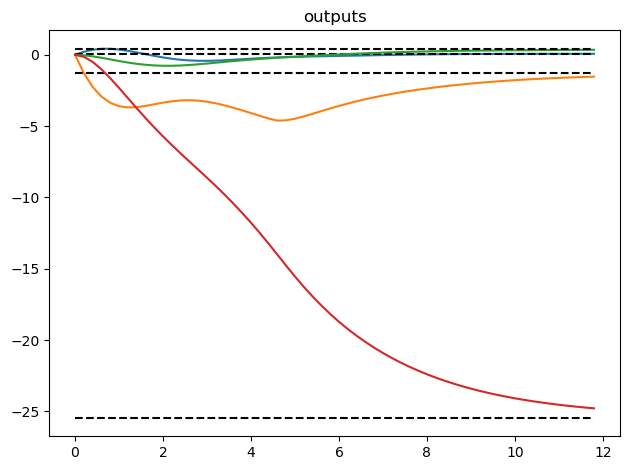

In [6]:
# Plot the results
# plt.subplot(2, 1, 1)
for i, y in enumerate(C @ xout):
    plt.plot(tout, y)
    plt.plot(tout, yd[i] * np.ones(tout.shape), 'k--')
plt.title('outputs')

# plt.subplot(2, 1, 2)
# plt.plot(t, u);
# plot(np.range(Nsim), us*ones(1, Nsim), 'k--')
# plt.title('inputs')

plt.tight_layout()

# Print the final error
xd - xout[:,-1]